In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_05 import *
torch.set_num_threads(2)

## ConvNet

In [ ]:
x_train,y_train,x_valid,y_valid = get_data()

In [ ]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [ ]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [ ]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [ ]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [ ]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

In [ ]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [ ]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [ ]:
model = get_cnn_model(data)

In [ ]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [ ]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [ ]:
%time run.fit(1, learn)

train: [2.0956815625, tensor(0.2509)]
valid: [1.204433984375, tensor(0.6120)]
CPU times: user 7.56 s, sys: 4.19 s, total: 11.7 s
Wall time: 3.95 s


## CUDA

In [ ]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [ ]:
cbfs.append(CudaCallback)

In [ ]:
model = get_cnn_model(data)

In [ ]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [1.827299375, tensor(0.3810, device='cuda:0')]
valid: [0.900947265625, tensor(0.6911, device='cuda:0')]
train: [0.4029501171875, tensor(0.8751, device='cuda:0')]
valid: [0.2031676025390625, tensor(0.9386, device='cuda:0')]
train: [0.18989078125, tensor(0.9427, device='cuda:0')]
valid: [0.13601285400390625, tensor(0.9584, device='cuda:0')]
CPU times: user 4.49 s, sys: 1.07 s, total: 5.56 s
Wall time: 5.48 s


## Refactor model

In [ ]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [ ]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [ ]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

This model can now work on any size input:

In [ ]:
nfs = [8,16,32,32]

In [ ]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [ ]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [ ]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [ ]:
run.fit(3, learn)

train: [2.2705175, tensor(0.1419, device='cuda:0')]
valid: [2.0939794921875, tensor(0.3091, device='cuda:0')]
train: [1.057326328125, tensor(0.6512, device='cuda:0')]
valid: [0.2755657958984375, tensor(0.9147, device='cuda:0')]
train: [0.2643435546875, tensor(0.9210, device='cuda:0')]
valid: [0.16342425537109376, tensor(0.9530, device='cuda:0')]


## Hooks

### Manual insertion

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [ ]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [ ]:
run.fit(2, learn)

train: [2.30377515625, tensor(0.1313, device='cuda:0')]
valid: [1.8905267578125, tensor(0.3152, device='cuda:0')]
train: [2.291239375, tensor(0.1314, device='cuda:0')]
valid: [2.4141302734375, tensor(0.1064, device='cuda:0')]


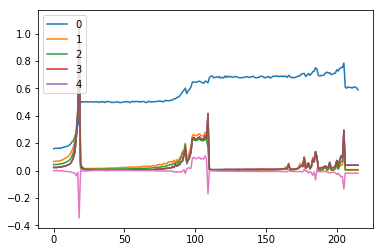

In [ ]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

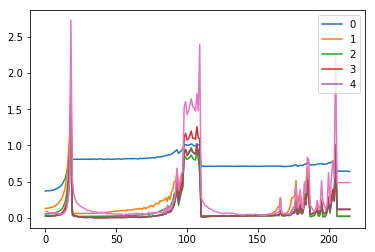

In [ ]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

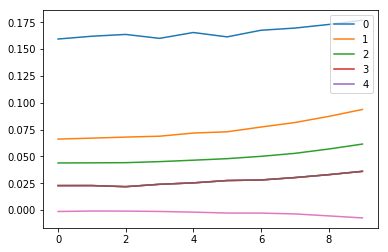

In [ ]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(5));

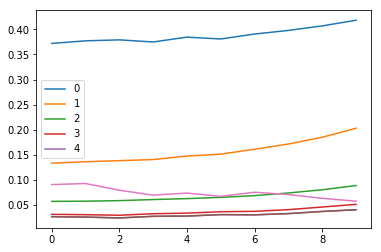

In [ ]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(5));

### Pytorch hooks

In [ ]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [ ]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [ ]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [ ]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [ ]:
run.fit(1, learn)

train: [1.967506875, tensor(0.3213, device='cuda:0')]
valid: [0.766159228515625, tensor(0.7892, device='cuda:0')]


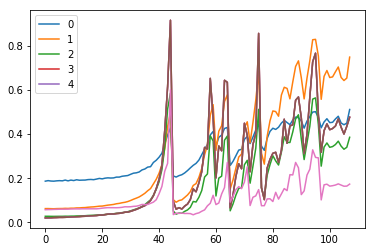

In [ ]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook class

In [ ]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [ ]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [ ]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [ ]:
run.fit(1, learn)

train: [1.80329453125, tensor(0.3844, device='cuda:0')]
valid: [0.77440634765625, tensor(0.7433, device='cuda:0')]


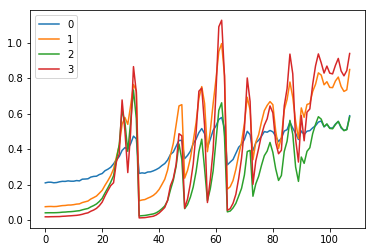

In [ ]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

### A Hooks class

In [ ]:
#export
class ListContainer():
    def __init__(self, items): self.items = items
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res += '...'
        return res

In [ ]:
ListContainer(range(10))

ListContainer (10 items)
range(0, 10)

In [ ]:
ListContainer(range(100))

ListContainer (100 items)
range(0, 10)...

In [ ]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

In [ ]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
        
    def remove(self):
        for h in self: h.remove()

In [ ]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [ ]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7fb7c00f86d8>, <__main__.Hook object at 0x7fb7c00f8e80>, <__main__.Hook object at 0x7fb7c00f8940>, <__main__.Hook object at 0x7fb7c00f88d0>, <__main__.Hook object at 0x7fb7c017df28>, <__main__.Hook object at 0x7fb7c017d8d0>, <__main__.Hook object at 0x7fb7c3c55240>]

In [ ]:
hooks.remove()

In [ ]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [ ]:
x.mean(),x.std()

(tensor(0.0102, device='cuda:0'), tensor(1.0100, device='cuda:0'))

In [ ]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.1451, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.2750, device='cuda:0', grad_fn=<StdBackward0>))

In [ ]:
for l in model:
    if isinstance(l, nn.Sequential): init.kaiming_normal_(l[0].weight)

In [ ]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.4385, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.9721, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.46415796875, tensor(0.5036, device='cuda:0')]
valid: [0.230704345703125, tensor(0.9317, device='cuda:0')]
train: [0.28694400390625, tensor(0.9129, device='cuda:0')]
valid: [0.1331471923828125, tensor(0.9601, device='cuda:0')]


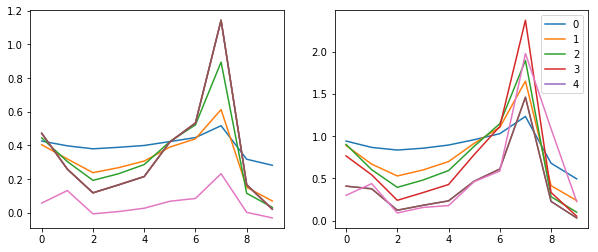

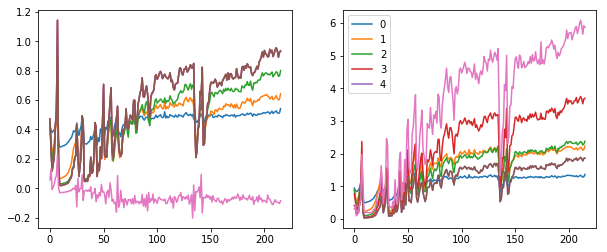

In [ ]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

### Other statistics

- pct < x
- percentiles

## Generalized ReLU

In [ ]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m):
    for l in m:
        if isinstance(l, nn.Sequential):
            init.kaiming_normal_(l[0].weight, a=0.1)
            l[0].weight.data

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [ ]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.4775627734375, tensor(0.8477, device='cuda:0')]
valid: [0.2363722412109375, tensor(0.9263, device='cuda:0')]
train: [0.128826494140625, tensor(0.9602, device='cuda:0')]
valid: [0.108266259765625, tensor(0.9664, device='cuda:0')]


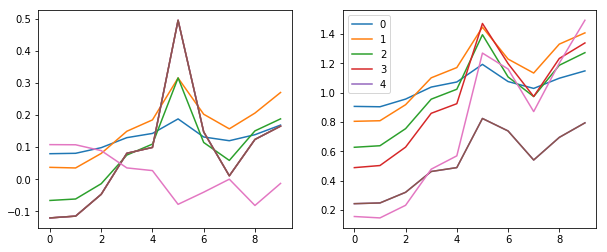

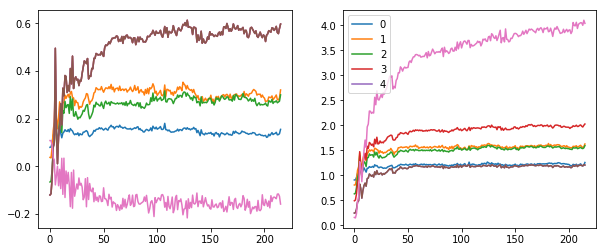

In [ ]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

In [ ]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 

In [ ]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=partial(ParamScheduler,'lr', sched))

In [ ]:
run.fit(8, learn)

train: [1.02442921875, tensor(0.6792, device='cuda:0')]
valid: [0.3060712646484375, tensor(0.9099, device='cuda:0')]
train: [0.3662448828125, tensor(0.8921, device='cuda:0')]
valid: [0.2617169677734375, tensor(0.9257, device='cuda:0')]
train: [0.19008404296875, tensor(0.9437, device='cuda:0')]
valid: [0.11017318115234374, tensor(0.9686, device='cuda:0')]
train: [0.1220571484375, tensor(0.9634, device='cuda:0')]
valid: [0.1188526611328125, tensor(0.9651, device='cuda:0')]
train: [0.4792731640625, tensor(0.8525, device='cuda:0')]
valid: [0.12017060546875, tensor(0.9624, device='cuda:0')]
train: [0.096011337890625, tensor(0.9706, device='cuda:0')]
valid: [0.09121909790039062, tensor(0.9712, device='cuda:0')]
train: [0.0692763671875, tensor(0.9783, device='cuda:0')]
valid: [0.07469473876953125, tensor(0.9782, device='cuda:0')]
train: [0.0578204541015625, tensor(0.9824, device='cuda:0')]
valid: [0.06969982299804688, tensor(0.9786, device='cuda:0')]


## Export

In [ ]:
!python notebook2script.py 06_cuda_cnn_hooks_init.ipynb

Converted 06_cuda_cnn_hooks_init.ipynb to nb_06.py
